# Feature Extractions With Images
- Name: Minh T. Nguyen
- Date: 11/24/2023
- About:
    - **Description Sentiment Analysis**: Use pretrained models to performed sentimental analysis and create new feature.
    - **Features Extraction**: Based on the provided features let's create new features.
        - Use the processed sentiment dataset
    - **Features Extraction From Images**: 
        - For the one with image, we want to count the unique furniture.
    - **Clean up the dataset for classical ML modeling.**

In [1]:
!ls ../data

final_dataset_image.json     sentimental_extraction_kaggle.csv
final_dataset_no_image.json  sentimental_extraction_kaggle.json
images_sample		     sentimental_extraction_sample.csv
Kaggle-renthop.torrent	     train.json


In [2]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


In [3]:
!pip install typing-extensions --upgrade

In [4]:
!pip3 install Cython

In [5]:
!pip install opencv-python

In [6]:
# import libraries
import numpy as np
import pandas as pd
from collections import Counter
import collections
import re
import os

import torch
from PIL import Image
from IPython.display import display 

import warnings
warnings.filterwarnings('ignore')

/home/mnguyen0226/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/mnguyen0226/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


## 1. Import dataset

In [7]:
# import the dataset (this dataset has already remove outlier)
df = pd.read_json("../data/sentimental_extraction_kaggle.json")
df.head(5)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level,clean_description,truncated_description,sentiment,sentiment_label
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,spacious 1 bedroom 1 bathroom in williamsburg!...,"{'label': 'POSITIVE', 'score': 0.8850623965000...",1
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,brand new gut renovated true 2 bedroomfind you...,"{'label': 'POSITIVE', 'score': 0.9983743429}",1
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,* * flex 2 bedroom with full pressurized wall ...,"{'label': 'POSITIVE', 'score': 0.9986716509}",1
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,a brand new 3 bedroom 1. 5 bath apartmentenjoy...,"{'label': 'NEGATIVE', 'score': 0.6298918724}",0
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,low,Over-sized Studio w abundant closets. Availabl...,over - sized studio w abundant closets. availa...,"{'label': 'NEGATIVE', 'score': 0.9978052974}",0


In [8]:
print(f"There are {len(df)} samples.")

There are 48871 samples.


In [9]:
# # use the first 5 row for test only
# df = df.head(5) 

## 2. Feature Extraction

In [10]:
# check the first 3 row's features list
print(df.features.iloc[0])
print(df.features.iloc[1])
print(df.features.iloc[2])

['Dining Room', 'Pre-War', 'Laundry in Building', 'Dishwasher', 'Hardwood Floors', 'Dogs Allowed', 'Cats Allowed']
['Doorman', 'Elevator', 'Laundry in Building', 'Dishwasher', 'Hardwood Floors', 'No Fee']
['Doorman', 'Elevator', 'Laundry in Building', 'Laundry in Unit', 'Dishwasher', 'Hardwood Floors']


In [11]:
# Flatten the list of features from all rows
all_features = [feature for sublist in df['features'] for feature in sublist]

# Count the frequency of each feature
feature_counts = Counter(all_features)

# Filter features that have a frequency above the threshold
frequency_threshold = 10000
high_freq_features = [feature for feature, count in feature_counts.items() if count >= frequency_threshold]

# Create binary columns for each high-frequency feature
for feature in high_freq_features:
    df['feature_' + feature.lower()] = df['features'].apply(lambda x: 1 if feature in x else 0)

In [12]:
print(f"The features with most (>= 10k) counts are {high_freq_features}")

The features with most (>= 10k) counts are ['Laundry in Building', 'Dishwasher', 'Hardwood Floors', 'Dogs Allowed', 'Cats Allowed', 'Doorman', 'Elevator', 'No Fee', 'Fitness Center']


In [13]:
# view the cleaned dataset with extracted features
df.head(5)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,sentiment_label,feature_laundry in building,feature_dishwasher,feature_hardwood floors,feature_dogs allowed,feature_cats allowed,feature_doorman,feature_elevator,feature_no fee,feature_fitness center
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,...,1,1,1,1,1,1,0,0,0,0
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,...,1,1,1,1,0,0,1,1,1,0
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,...,1,1,1,1,0,0,1,1,0,0
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,...,0,0,0,0,0,0,0,0,0,0
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,...,0,1,0,0,0,0,1,1,0,1


## 3. Image Feature Extraction

In [14]:
# filter out dataset that has the matching ID
images_sample_path = '../data/images_sample/images_sample/'

# list all folders in the images_sample directory
folder_names = [f.name for f in os.scandir(images_sample_path) if f.is_dir() and not f.name.startswith('__')]

# convert folder names to integers if your listing_id is an integer
listing_ids_with_images = [int(folder_name) for folder_name in folder_names]

# filter the DataFrame
df_with_images = df[df['listing_id'].isin(listing_ids_with_images)]

In [15]:
# view the cleaned dataset that has image in the local machine
df_with_images.head(5)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,sentiment_label,feature_laundry in building,feature_dishwasher,feature_hardwood floors,feature_dogs allowed,feature_cats allowed,feature_doorman,feature_elevator,feature_no fee,feature_fitness center
83181,1.0,1,0,2016-04-02 01:21:29,Beautiful one bedroom apartment like no other!...,East 69th Street,"[Doorman, Dogs Allowed, Cats Allowed]",40.7675,6812258,-73.9607,...,1,0,0,0,1,1,1,0,0,0
84383,1.0,1,0,2016-04-02 01:14:55,Currently occupied - sorry.Appointments only. ...,East 37th Street,[Pre-War],40.7476,6812086,-73.9760,...,1,0,0,0,0,0,0,0,0,0
88044,1.0,1,0,2016-04-02 01:18:55,junior 1 bedroom in financial district in a la...,Wall Street,"[Doorman, Fitness Center, Pre-War, Dogs Allowe...",40.7067,6812179,-74.0101,...,1,0,0,0,1,1,1,0,0,1
88259,1.0,3,0,2016-04-02 01:16:08,++NEW!! SUNNY 3BR on PARK AVENUE and IRVING PL...,Park Avenue South,[Pre-War],40.7378,6812107,-73.9877,...,1,0,0,0,0,0,0,0,0,0
88512,1.0,0,0,2016-04-02 01:19:25,- Location Location Location -Pet Friendly Spa...,Second Avenue,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7672,6812198,-73.9592,...,1,0,0,0,1,1,0,0,0,0


In [16]:
print(f"There are {len(df_with_images)} samples that has the image in the local machines only.")

There are 42 samples that has the image in the local machines only.


### Extract counts with sampled images
- From the listing id of `6812258`, let's see if we can extract features from its images.

Using cache found in /home/mnguyen0226/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-11-25 Python-3.9.7 torch-2.1.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
image 1/1: 640x426 (no detections)
Speed: 8.1ms pre-process, 164.0ms inference, 0.7ms NMS per image at shape (1, 3, 640, 448)


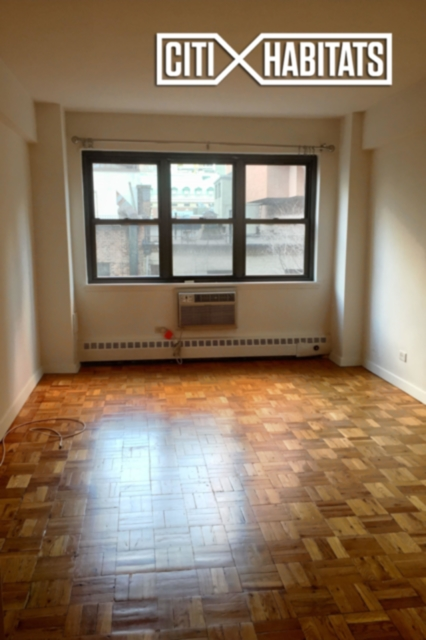

image 1/1: 640x426 2 ovens, 1 sink, 1 refrigerator
Speed: 4.8ms pre-process, 141.6ms inference, 1.4ms NMS per image at shape (1, 3, 640, 448)


{}


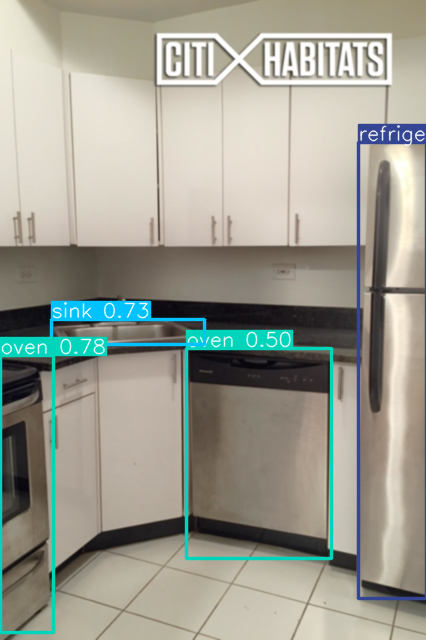

{'oven': 2, 'refrigerator': 1, 'sink': 1}


image 1/1: 640x426 1 toilet, 1 sink
Speed: 4.4ms pre-process, 141.0ms inference, 2.5ms NMS per image at shape (1, 3, 640, 448)


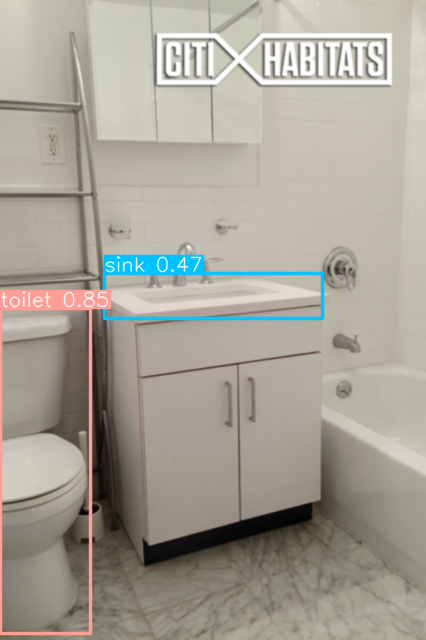

{'toilet': 1, 'sink': 1}


image 1/1: 426x640 (no detections)
Speed: 5.4ms pre-process, 158.4ms inference, 0.5ms NMS per image at shape (1, 3, 448, 640)


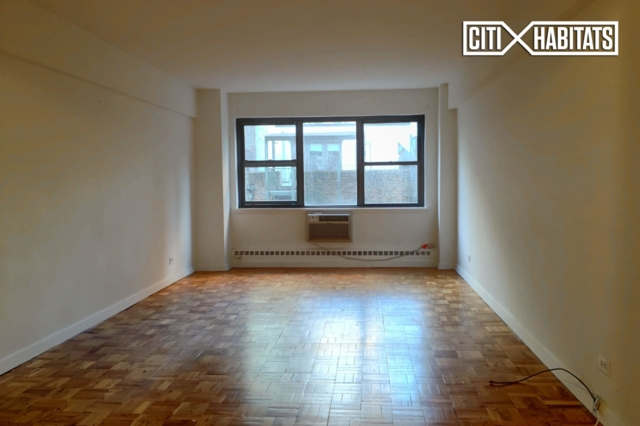

{}


In [17]:
id_list = df_with_images.listing_id.values

# Load the model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

item_id = str(id_list[0])
folder_path = "../data/images_sample/images_sample/" + item_id + "/"
files = os.listdir(folder_path)

for image in files:
    img = Image.open("../data/images_sample/images_sample/"+ item_id + "/" + image)
    results = model(img)
    results.print() 
    results.show()  
    counts = results.pandas().xyxy[0]['name'].value_counts().to_dict()
    print(counts)

In [18]:
# load the model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# init an empty dictionary to store the counts
property_item_counts = collections.defaultdict(lambda: collections.defaultdict(int))

images_sample_path = "../data/images_sample/images_sample/"

# list of property match with the directory
id_list = df_with_images.listing_id.values

# loop over each property
for item_id in id_list:
    folder_path = os.path.join(images_sample_path, str(item_id))
    
    # check if the folder exists
    if not os.path.exists(folder_path):
        continue
    
    files = os.listdir(folder_path)
    
    # loop over each image in the property's folder
    for image in files:
        image_path = os.path.join(folder_path, image)
        
        # ensure it's a file and not a directory
        if os.path.isfile(image_path):
            try:
                img = Image.open(image_path)
                results = model(img)
                counts = results.pandas().xyxy[0]['name'].value_counts().to_dict()
                
                # accumulate the counts for each detected item
                for item, count in counts.items():
                    property_item_counts[item_id][item] += count
                    
            except Exception as e:
                print(f"Error processing image {image_path}: {e}")

Using cache found in /home/mnguyen0226/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-11-25 Python-3.9.7 torch-2.1.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [19]:
# show dictionary
property_item_counts

defaultdict(<function __main__.<lambda>()>,
            {6812258: defaultdict(int,
                         {'oven': 2,
                          'refrigerator': 1,
                          'sink': 2,
                          'toilet': 1}),
             6812179: defaultdict(int,
                         {'person': 14,
                          'chair': 4,
                          'couch': 1,
                          'bench': 4,
                          'dining table': 1,
                          'potted plant': 1}),
             6812107: defaultdict(int,
                         {'oven': 1,
                          'sink': 2,
                          'refrigerator': 1,
                          'toilet': 1}),
             6812198: defaultdict(int,
                         {'bowl': 2,
                          'bottle': 2,
                          'oven': 1,
                          'toaster': 1,
                          'sink': 2,
                          'refrigerator': 1,

In [20]:
# aggregate counts for each item across all properties
total_item_counts = collections.defaultdict(int)

for item_counts in property_item_counts.values():
    for item, count in item_counts.items():
        total_item_counts[item] += count

# determine items with the highest counts, select top 10 most frequent items
top_items = sorted(total_item_counts.items(), key=lambda x: x[1], reverse=True)[:10]
top_item_names = [item[0] for item in top_items]

In [21]:
# show top detected items
top_item_names

['chair',
 'sink',
 'oven',
 'refrigerator',
 'toilet',
 'person',
 'potted plant',
 'microwave',
 'bottle',
 'tv']

In [22]:
# show top detected items
top_items

[('chair', 37),
 ('sink', 36),
 ('oven', 33),
 ('refrigerator', 26),
 ('toilet', 24),
 ('person', 24),
 ('potted plant', 14),
 ('microwave', 14),
 ('bottle', 12),
 ('tv', 11)]

In [23]:
# for each property, create feature columns for each of these items
for item in top_item_names:
    # init columns with zeros
    df_with_images[item + '_count'] = 0

# populate the item count columns for each property
for idx, row in df_with_images.iterrows():
    item_id = row['listing_id']
    for item in top_item_names:
        # set the item count for this property
        df_with_images.at[idx, item + '_count'] = property_item_counts[item_id][item]

In [24]:
df_with_images

,bathrooms,bedrooms,building_id,created,description,...,person_count,potted plant_count,microwave_count,bottle_count,tv_count
83181,1.0,1,0,2016-04-02 01:21:29,Beautiful one bedroom apartment like no other!...,...,0,0,0,0,0
84383,1.0,1,0,2016-04-02 01:14:55,Currently occupied - sorry.Appointments only. ...,...,0,0,0,0,0
88044,1.0,1,0,2016-04-02 01:18:55,junior 1 bedroom in financial district in a la...,...,14,1,0,0,0
88259,1.0,3,0,2016-04-02 01:16:08,++NEW!! SUNNY 3BR on PARK AVENUE and IRVING PL...,...,0,0,0,0,0
88512,1.0,0,0,2016-04-02 01:19:25,- Location Location Location -Pet Friendly Spa...,...,0,1,0,2,2
88596,1.0,1,0,2016-04-02 01:19:35,"**East 70's/First Avenue** Large, One Bedroom ...",...,1,0,0,6,1
88762,1.0,2,0,2016-04-02 01:11:40,Fantastic two bedroom apartment in PRIME Inwoo...,...,0,0,0,0,0
89421,1.0,1,0,2016-04-02 01:13:59,"LEXINGTON AVE! EAST 22ND.Prime downtown, Grame...",...,0,0,3,0,0
90388,1.0,2,0,2016-04-02 01:11:30,photos coming soon...............................,...,0,0,0,0,0
90518,1.0,1,0,2016-04-02 01:21:28,THIRD AVE! Apartment Features: Dining Area; |P...,...,0,0,0,0,0


## 4. Dataset Clean Up

In [25]:
# convert target interest_level from categorical to numerical
interest_level_mapping = {'high': 1, 'medium': 0, 'low': -1}
df_with_images['interest_level'] = df_with_images['interest_level'].map(interest_level_mapping)

In [26]:
# extract numerical features
final_df = df_with_images[['bathrooms', 'bedrooms', 'price', 'sentiment_label', 
                    'feature_laundry in building', 'feature_dishwasher', 'feature_hardwood floors', # from feature column
                    'feature_dogs allowed', 'feature_cats allowed', 'feature_doorman', 'feature_elevator',
                    'feature_no fee', 'feature_fitness center', 
               'chair_count', 'sink_count', 'oven_count', 'refrigerator_count', # from images
               'toilet_count', 'person_count', 'potted plant_count', 'microwave_count',
               'bottle_count', 'tv_count', 'interest_level']]

In [27]:
# check the dataset
final_df.head(5)

,bathrooms,bedrooms,price,sentiment_label,feature_laundry in building,...,potted plant_count,microwave_count,bottle_count,tv_count,interest_level
83181,1.0,1,3807,1,0,...,0,0,0,0,-1
84383,1.0,1,2875,1,0,...,0,0,0,0,-1
88044,1.0,1,3535,1,0,...,1,0,0,0,-1
88259,1.0,3,5595,1,0,...,0,0,0,0,-1
88512,1.0,0,1875,1,0,...,1,0,2,2,-1


In [28]:
# export dataset
final_df.to_json("../data/final_dataset_image.json")

In [29]:
final_df.interest_level

83181    -1
84383    -1
88044    -1
88259    -1
88512    -1
88596    -1
88762    -1
89421    -1
90388    -1
90518    -1
93083    -1
93559    -1
94499    -1
96685    -1
97728    -1
103006   -1
103149   -1
103891    0
104518   -1
105440   -1
108025   -1
109072   -1
110010    0
110938   -1
111634   -1
111817    1
113404   -1
113460   -1
114617    1
115189   -1
115303   -1
117094   -1
117348   -1
117474    0
117995    0
120266   -1
120626   -1
121624   -1
122220   -1
122334   -1
123756   -1
123980   -1
Name: interest_level, dtype: int64